# Set up

Setting up libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Data

/content/drive/My Drive/Colab Notebooks/Data


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import pickle
import seaborn as sns
import tensorflow_probability as tfp

from skimage.transform import radon, iradon
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

# Opening variables with pickle

In [ ]:
with open('variables', 'rb') as f:
   train,train_labs,valid,valid_labs,test,test_labs,test_labels = pickle.load(f)

# Standard model

In [ ]:
class physical(tf.keras.layers.Layer):
    def __init__(self,name = None, **kwargs):
      super(physical, self).__init__(name=name)
      super(physical, self).__init__(**kwargs)
      self.p_layer = tf.Variable(initial_value = tf.keras.initializers.Ones()(shape=(1,256)), trainable = True)

    @tf.function
    def get_temp(self):
        soft_choice = self.p_layer
        values, indices  = tf.math.top_k(soft_choice, k=(256-63))
        hard_choice = tf.cast(tf.where(soft_choice > tf.reduce_min(values),x = 0.0, y = 0.5),tf.float32)
        choice = soft_choice - tf.stop_gradient(hard_choice)
        return choice
    
    @tf.function
    def call(self, inputs):
      choice = self.get_temp()
      choice = tf.repeat(choice, 256, axis = 0)
      choice = tf.repeat(choice[..., tf.newaxis], 3, -1)
      new_choice = tf.math.multiply(inputs, choice)
      return new_choice

In [ ]:
inception = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(256,256,3)
)

for layer in inception.layers:
    layer.trainable = False

model = Sequential()
model.add(physical())
model.add(inception)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation = 'softmax'))

In [ ]:
loss_fn_name = "categorical_crossentropy"
Metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),loss=loss_fn_name, metrics=Metrics)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

mcp = tf.keras.callbacks.ModelCheckpoint('new_model.h5',monitor='val_accuracy', mode='max', save_best_only=True)

history = model.fit(train, train_labs, epochs=35, batch_size=64, validation_data=(valid, valid_labs),callbacks=[es,mcp])

Epoch 1/35
10/10 [==============================] - 274s 27s/step - loss: 84586.1875 - accuracy: 0.2662 - precision: 0.2662 - recall: 0.2662 - auc: 0.5108 - val_loss: 30883.7949 - val_accuracy: 0.2917 - val_precision: 0.2917 - val_recall: 0.2917 - val_auc: 0.5278
Epoch 2/35
10/10 [==============================] - 254s 25s/step - loss: 23913.6465 - accuracy: 0.3461 - precision: 0.3461 - recall: 0.3461 - auc: 0.5637 - val_loss: 24206.3281 - val_accuracy: 0.2639 - val_precision: 0.2639 - val_recall: 0.2639 - val_auc: 0.5093
Epoch 3/35
10/10 [==============================] - 253s 25s/step - loss: 14626.2344 - accuracy: 0.3727 - precision: 0.3727 - recall: 0.3727 - auc: 0.5818 - val_loss: 9788.0000 - val_accuracy: 0.3889 - val_precision: 0.3889 - val_recall: 0.3889 - val_auc: 0.5926
Epoch 4/35
10/10 [==============================] - 249s 24s/step - loss: 10433.3701 - accuracy: 0.3710 - precision: 0.3710 - recall: 0.3710 - auc: 0.5807 - val_loss: 2259.6450 - val_accuracy: 0.3472 - val_pre

# Evaluating and looking at most useful angles

In [ ]:
best_model = load_model('new_model.h5',custom_objects={"physical": physical})
best_model.evaluate(x = test, y = test_labs, verbose=1)

10/10 [==============================] - 42s 4s/step - loss: 771.9126 - accuracy: 0.4190 - precision: 0.4190 - recall: 0.4190 - auc: 0.6141


[771.91259765625,
 0.41904762387275696,
 0.41904762387275696,
 0.41904762387275696,
 0.6141127943992615]

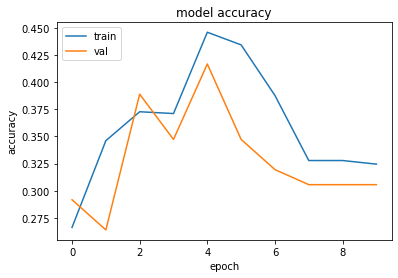

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

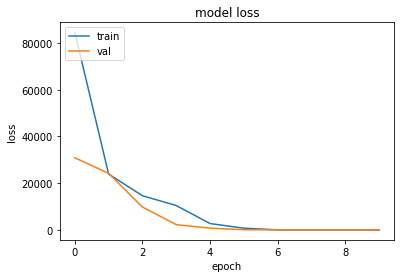

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = best_model.predict(test)

In [ ]:
cf_matrix = confusion_matrix(test_labels, preds.argmax(axis=1))

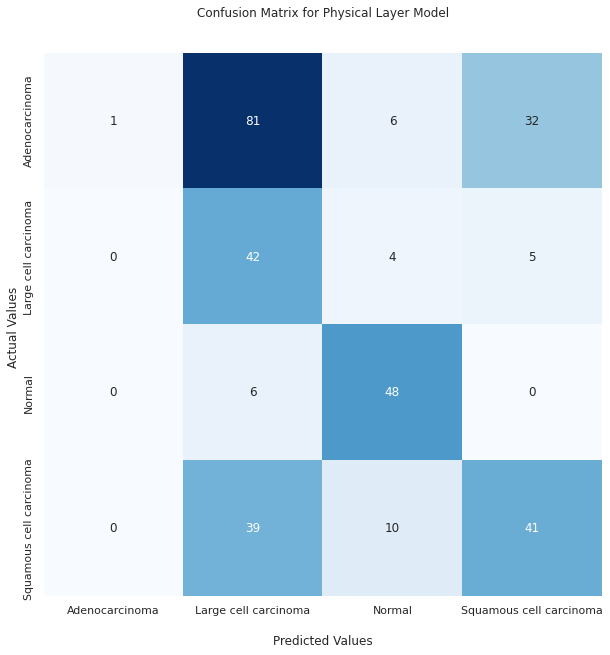

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',cbar=False,fmt='g')

ax.set_title('Confusion Matrix for Physical Layer Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])
ax.yaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])

plt.show()

In [ ]:
np.round(best_model.layers[0].get_temp().numpy()[0])

array([1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 0.

In [ ]:
def four_to_two(pred):
  pred_2 = [] 
  for i in range(len(pred)):
    if pred[i] == 0 or pred[i] == 1 or pred[i] == 3: 
      pred_2.append(1)
    else:
      pred_2.append(0)
  return pred_2

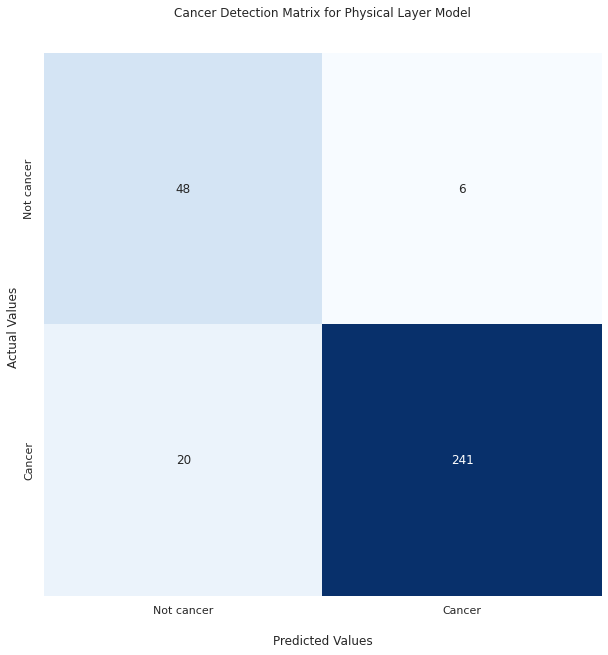

In [ ]:
preds_in_one = preds.argmax(axis=1)

new_pred = four_to_two(preds_in_one)
new_test_labels = four_to_two(test_labels)

cf_matrix_2 = confusion_matrix(new_test_labels, new_pred)

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix_2, annot=True, cmap='Blues',cbar=False,fmt = 'g')

ax.set_title('Cancer Detection Matrix for Physical Layer Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Not cancer','Cancer'])
ax.yaxis.set_ticklabels(['Not cancer','Cancer'])

plt.show()

# Saving best angle

In [ ]:
best_angle = best_model.layers[0].get_temp().numpy()[0]
with open('angles', 'wb') as f:
  pickle.dump([best_angle],f)

# Metrics

In [ ]:
def scores(y_true, y_pred, labels):
  acc = metrics.accuracy_score(y_true, y_pred.argmax(axis=1))
  acc_k = metrics.top_k_accuracy_score(y_true, y_pred, k=2)
  acc_3 = metrics.top_k_accuracy_score(y_true, y_pred, k=3)
  prec = metrics.precision_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  rec = metrics.recall_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  roc_auc = metrics.roc_auc_score(labels, y_pred)

  print('Accuracy is :',round(acc,3))
  print('Top 2 Accuracy is :',round(acc_k,3))
  print('Top 3 Accuracy is :',round(acc_3,3))
  print('Precision is :',round(prec,3))
  print('Recall is :',round(rec,3))
  print('AUC is :',round(roc_auc,3))

In [ ]:
scores(test_labels,preds,test_labs)

Accuracy is : 0.419
Top 2 Accuracy is : 0.578
Top 3 Accuracy is : 0.622
Precision is : 0.693
Recall is : 0.419
AUC is : 0.685
